In [435]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf

In [436]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [437]:
df_train2= df_train.copy().drop(['Transported'],axis=1)

df_train2.shape


(8693, 13)

In [438]:
data = pd.concat([df_train2, df_test], axis = 0).reset_index(drop = True)

data.shape

(12970, 13)

In [439]:
# Data from the Cabin
data[["CabinDeck", "CabinNo.", "CabinSide"]] = data["Cabin"].str.split('/', expand = True)

In [440]:
data["PassengerGroup"] = data["PassengerId"].str.split('_', expand = True)[0]

In [441]:
No_People_In_PassengerGroup = data.groupby('PassengerGroup').aggregate({'PassengerId': 'size'}).reset_index()
No_People_In_PassengerGroup = No_People_In_PassengerGroup.rename(columns = {"PassengerId": "NoInPassengerGroup"})

data = data.merge(No_People_In_PassengerGroup[["PassengerGroup", "NoInPassengerGroup"]], how = 'left', on = ['PassengerGroup'])


In [442]:
# Data from the group
No_People_In_PassengerGroup["IsAlone"] = No_People_In_PassengerGroup["NoInPassengerGroup"].apply(lambda x: False if x > 1 else True)
data = data.merge(No_People_In_PassengerGroup[["PassengerGroup", "IsAlone"]], how = 'left', on = ['PassengerGroup'])

In [443]:
# Filling NaNs based on Age
def fill_nans_by_age_and_cryosleep(df):
    df["RoomService"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["RoomService"])
    df["FoodCourt"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["FoodCourt"])
    df["ShoppingMall"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["ShoppingMall"])
    df["Spa"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["Spa"])
    df["VRDeck"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["VRDeck"])

    return df

data = fill_nans_by_age_and_cryosleep(data)


In [444]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,PassengerGroup,NoInPassengerGroup,IsAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,0001,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,0002,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,0003,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,0003,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,0004,1,True


In [ ]:
data2 = data.copy()

In [ ]:
data2['Regular_exp'] = data2['ShoppingMall'] + data2['FoodCourt']
data2['Luxury_exp'] = data2['RoomService'] + data2['Spa'] + data2['VRDeck']

data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,PassengerGroup,NoInPassengerGroup,IsAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,0001,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,0002,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,0003,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,0003,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,0004,1,True


In [ ]:
data2.to_csv('data2.csv')

In [ ]:
data.isnull().sum().sort_values(ascending=False)

CryoSleep             310
Cabin                 299
CabinDeck             299
CabinNo.              299
CabinSide             299
VIP                   296
Name                  294
HomePlanet            288
Destination           274
Age                   270
FoodCourt             171
Spa                   166
ShoppingMall          163
RoomService           162
VRDeck                150
NoInPassengerGroup      0
PassengerId             0
PassengerGroup          0
IsAlone                 0
dtype: int64

## Correr desde aqui para Cryo Data

In [382]:
cryo_data = data.copy()

In [383]:
cryo_data = cryo_data.drop(['CabinNo.', 'PassengerGroup', 'Name','NoInPassengerGroup', 'Cabin', 'PassengerId'],axis =1)

In [384]:
cryo_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,IsAlone
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S,True


In [385]:
missing_categorical_columns = cryo_data.select_dtypes(include=['object','bool']).isna().sum() > 0
missing_categorical_columns = list(missing_categorical_columns[missing_categorical_columns].index)
missing_categorical_columns.remove('CryoSleep')
missing_categorical_columns

['HomePlanet', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

In [386]:
for col in missing_categorical_columns:
    cryo_data[col] = cryo_data[col].fillna(cryo_data[col].mode()[0])

In [387]:
cryo_data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
HomePlanet        0
Destination       0
VIP               0
CabinDeck         0
CabinSide         0
IsAlone           0
dtype: int64

In [388]:
missing_numerical_columns = cryo_data.select_dtypes(include=['int','float64']).isna().sum() > 0
missing_numerical_columns = list(missing_numerical_columns[missing_numerical_columns].index)

print(missing_numerical_columns)

for col in missing_numerical_columns:
    cryo_data[col] = cryo_data[col].fillna(cryo_data[col].mean())

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [389]:
cryo_data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
HomePlanet        0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
CabinDeck         0
CabinSide         0
IsAlone           0
dtype: int64

In [390]:
null_cryo = cryo_data[cryo_data['CryoSleep'].isnull()]

In [391]:
has_cryo = cryo_data[cryo_data['CryoSleep'].notnull()]

In [392]:
has_cryo.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
CabinDeck       0
CabinSide       0
IsAlone         0
dtype: int64

In [359]:
has_cryo = has_cryo.dropna()

In [393]:
has_cryo.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
CabinDeck       0
CabinSide       0
IsAlone         0
dtype: int64

In [394]:
# Separate the target and the features variables
y = has_cryo["CryoSleep"]
X = has_cryo.drop(columns="CryoSleep")


In [395]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns

print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Index(['HomePlanet', 'Destination', 'VIP', 'CabinDeck', 'CabinSide',
       'IsAlone'],
      dtype='object')


In [396]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('numeric', StandardScaler(), numerical_columns)
        ])

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [398]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [399]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.709991,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.016645,2.217769,-0.281844,0.124948,-0.137953,-0.259010
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.228313,-0.346252,-0.138465,-0.298044,0.151414,-0.259010
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-1.465033,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-0.336135,0.785973,-0.102774,0.228075,-0.278554,-0.259010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10123,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,-0.124467,0.368109,-0.283074,-0.165204,-0.276740,0.485553
10124,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,2.062772,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010
10125,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.933874,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010
10126,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.000556,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010


In [400]:
X_train.shape

(10128, 26)

In [401]:
y_train

6518     False
8784     False
4654     False
8319     False
5899     False
         ...  
11164    False
591       True
5992      True
2496      True
7374      True
Name: CryoSleep, Length: 10128, dtype: object

In [402]:
y_train = y_train.astype(int)
y_train

6518     0
8784     0
4654     0
8319     0
5899     0
        ..
11164    0
591      1
5992     1
2496     1
7374     1
Name: CryoSleep, Length: 10128, dtype: int64

In [403]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=60, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=40, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 60)                1620      
                                                                 
 dense_45 (Dense)            (None, 50)                3050      
                                                                 
 dense_46 (Dense)            (None, 40)                2040      
                                                                 
 dense_47 (Dense)            (None, 1)                 41        
                                                                 
Total params: 6751 (26.37 KB)
Trainable params: 6751 (26.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=True)

In [406]:
y_test = y_test.astype(int)
y_test

2965     0
11871    0
12312    1
8606     0
4093     0
        ..
11380    0
10044    0
5830     1
601      1
9901     1
Name: CryoSleep, Length: 2532, dtype: int64

In [407]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

80/80 [==============================] - 0s 2ms/step - loss: 0.1047 - accuracy: 0.9502
Test accuracy: 0.950236976146698, Test loss: 0.10468881577253342


In [405]:
null_cryo.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,IsAlone
92,Earth,NaN,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.000000,G,P,False
98,Earth,NaN,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.000000,F,P,True
104,Europa,NaN,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.000000,B,P,False
111,Mars,NaN,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,303.965679,F,P,True
152,Earth,NaN,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.000000,E,S,True


In [409]:
X_pred = null_cryo.drop(columns="CryoSleep")
X_pred

,HomePlanet,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,IsAlone
92,Earth,TRAPPIST-1e,2.0,False,0.0,0.0,0.000000,0.0,0.000000,G,P,False
98,Earth,TRAPPIST-1e,27.0,False,0.0,0.0,570.000000,2.0,131.000000,F,P,True
104,Europa,TRAPPIST-1e,40.0,False,0.0,331.0,0.000000,0.0,1687.000000,B,P,False
111,Mars,TRAPPIST-1e,26.0,False,0.0,0.0,0.000000,0.0,303.965679,F,P,True
152,Earth,TRAPPIST-1e,58.0,False,0.0,985.0,0.000000,5.0,0.000000,E,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12688,Mars,55 Cancri e,20.0,False,0.0,0.0,0.000000,0.0,0.000000,F,P,True
12801,Europa,TRAPPIST-1e,27.0,False,0.0,2182.0,7.000000,2582.0,19.000000,C,P,False
12902,Europa,TRAPPIST-1e,41.0,False,0.0,1998.0,0.000000,1023.0,867.000000,F,S,True
12923,Earth,TRAPPIST-1e,14.0,False,0.0,0.0,172.953073,1377.0,29.000000,F,S,True


In [410]:
X_pred = preprocessor.transform(X_pred)

In [411]:
pd.DataFrame(X_pred)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1.888369,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-0.124467,-0.346252,-0.283074,0.698260,-0.276740,-0.148548
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.792762,-0.346252,-0.079391,-0.298044,-0.278554,1.163502
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-0.195023,-0.346252,-0.283074,-0.298044,-0.278554,-0.002700
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,2.062772,-0.346252,0.323053,-0.298044,-0.274019,-0.259010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-0.618360,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010
306,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-0.124467,-0.346252,1.059636,-0.285809,2.063592,-0.242989
307,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.863318,-0.346252,0.946411,-0.298044,0.649415,0.472062
308,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,-1.041696,-0.346252,-0.283074,0.004261,0.970530,-0.234557


In [412]:
predictions = (model.predict(X_pred)[:,0]>0.5).astype(bool)

10/10 [==============================] - 0s 6ms/step


In [413]:
pd.DataFrame(predictions)

,0
0,True
1,False
2,False
3,False
4,False
...,...
305,True
306,False
307,False
308,False


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

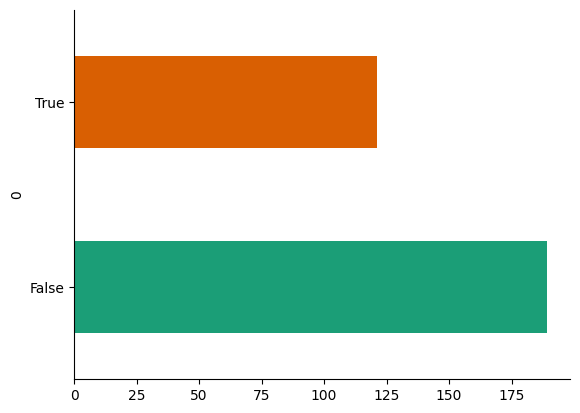

In [414]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [415]:
null_cryo['CryoSleep'] = predictions
null_cryo

<ipython-input-415-6acac6c52771>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_cryo['CryoSleep'] = predictions


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,IsAlone
92,Earth,True,TRAPPIST-1e,2.0,False,0.0,0.0,0.000000,0.0,0.000000,G,P,False
98,Earth,False,TRAPPIST-1e,27.0,False,0.0,0.0,570.000000,2.0,131.000000,F,P,True
104,Europa,False,TRAPPIST-1e,40.0,False,0.0,331.0,0.000000,0.0,1687.000000,B,P,False
111,Mars,False,TRAPPIST-1e,26.0,False,0.0,0.0,0.000000,0.0,303.965679,F,P,True
152,Earth,False,TRAPPIST-1e,58.0,False,0.0,985.0,0.000000,5.0,0.000000,E,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,Mars,True,55 Cancri e,20.0,False,0.0,0.0,0.000000,0.0,0.000000,F,P,True
12801,Europa,False,TRAPPIST-1e,27.0,False,0.0,2182.0,7.000000,2582.0,19.000000,C,P,False
12902,Europa,False,TRAPPIST-1e,41.0,False,0.0,1998.0,0.000000,1023.0,867.000000,F,S,True
12923,Earth,False,TRAPPIST-1e,14.0,False,0.0,0.0,172.953073,1377.0,29.000000,F,S,True


In [418]:
data.isnull().sum().sort_values(ascending=False)

CryoSleep             310
Cabin                 299
CabinDeck             299
CabinNo.              299
CabinSide             299
VIP                   296
Name                  294
HomePlanet            288
Destination           274
Age                   270
FoodCourt             171
Spa                   166
ShoppingMall          163
RoomService           162
VRDeck                150
NoInPassengerGroup      0
PassengerId             0
PassengerGroup          0
IsAlone                 0
dtype: int64

In [447]:
datam = data.copy()

In [449]:
datam['CryoSleep'] = datam['CryoSleep'].fillna(null_cryo['CryoSleep'])




In [450]:
datam.isnull().sum().sort_values(ascending=False)

Cabin                 299
CabinDeck             299
CabinNo.              299
CabinSide             299
VIP                   296
Name                  294
HomePlanet            288
Destination           274
Age                   270
FoodCourt             171
Spa                   166
ShoppingMall          163
RoomService           162
VRDeck                150
PassengerGroup          0
NoInPassengerGroup      0
PassengerId             0
CryoSleep               0
IsAlone                 0
dtype: int64

In [ ]:
datam.iloc[92:111]['CryoSleep']

In [ ]:
data.iloc[92:111]['CryoSleep']

In [461]:
datam = fill_nans_by_age_and_cryosleep(datam)

In [462]:
datam.isnull().sum().sort_values(ascending=False)

Cabin                 299
CabinDeck             299
CabinNo.              299
CabinSide             299
VIP                   296
Name                  294
HomePlanet            288
Destination           274
Age                   270
FoodCourt             171
Spa                   164
ShoppingMall          162
RoomService           162
VRDeck                150
PassengerGroup          0
NoInPassengerGroup      0
PassengerId             0
CryoSleep               0
IsAlone                 0
dtype: int64

In [ ]:
datam.to_csv('updated.csv')